## There are two methods that can be used to read data, which are mentioned in the following code for each method
> * 1. Creating a data frame and saving the path and label of each image in the data frame
> *   1.1 load images and labels in ram 
> *   1.2 Use flow_from_dataframe for read data
> * 2. Use flow_from_Directory for read data:
>   This method both reads the images and assigns its appropriate label to each image
   

In [2]:
'''
Creating a data frame and saving the path and label of each image in the data frame
'''
import os 
import cv2
import random
import warnings
import time
import sys
import os
import math
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
from torch.utils.data import Dataset
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms, datasets
ImageFile.LOAD_TRUNCATED_IMAGES = True
warnings.filterwarnings('ignore')
batch_size = 64
image_size = 224
path = '/kaggle/input/brain-tumor-classification-mri/'
class_label= ["no_tumor", "pituitary_tumor", "meningioma_tumor", "glioma_tumor"]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def generate_datafram(path):
    train_labels = []
    train_images = []

    test_labels = []
    test_images = []

    for sub_dir,dir,files in os.walk(path):
        for file in files:
            img_path = os.path.join(sub_dir,file)
            if img_path.split('/')[-3] == 'Training':
                train_images.append(os.path.join(img_path.split('/')[-3],img_path.split('/')[-2],img_path.split('/')[-1]))
                train_labels.append(img_path.split('/')[-2])
            elif img_path.split('/')[-3] == 'Testing':
                train_images.append(os.path.join(img_path.split('/')[-3],img_path.split('/')[-2],img_path.split('/')[-1]))
               
                train_labels.append(img_path.split('/')[-2])
    df = pd.DataFrame(list(zip(train_images,train_labels)),columns = ['id_code','diagnosis'])
#     test_df = pd.DataFrame(list(zip(test_images,test_labels)),columns = ['id_code','diagnosis'])
    return df
labelencoder = LabelEncoder()
df=generate_datafram(path)
df['diagnosis'] = labelencoder.fit_transform(df['diagnosis'])


In [3]:
labelencoder = LabelEncoder()
labelencoder.fit_transform(class_label)


array([2, 3, 1, 0])

<AxesSubplot:>

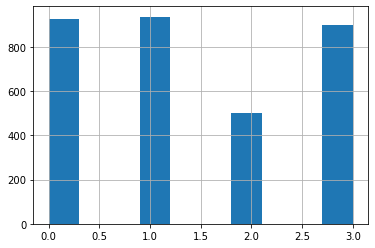

In [4]:
df['diagnosis'].hist()

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
X_train,X_test,Y_train,Y_test=train_test_split(df['id_code'],df['diagnosis'],test_size=.2)

In [6]:
train_df = pd.DataFrame(list(zip(X_train,Y_train)),columns = ['id_code','diagnosis'])
test_df = pd.DataFrame(list(zip(X_test,Y_test)),columns = ['id_code','diagnosis'])

In [7]:

### image preprocessing function
def prepare_image(path):
    # import image
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    # resize and color
    image = cv2.resize(image, (int(image_size), int(image_size)))
    image = image.astype("float32") / 255.0
    # convert to tensor    
    image = torch.tensor(image)
    image = image.permute(2, 1, 0)
    return image



In [8]:

# dataset class: train
class TomurTrainData(Dataset):
    
    # initialize
    def __init__(self, data, directory, transform = None):
        self.data      = data
        self.directory = directory
        self.transform = transform
        
    # length
    def __len__(self):
        return len(self.data)
    
    # get items    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'id_code'] )
        image    = prepare_image(img_name)
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'diagnosis'])
        return {'image': image, 'label': label}
    
    
# dataset class: test
class TomurTestData(Dataset):
    
    # initialize
    def __init__(self, data, directory, transform = None):
        self.data      = data
        self.directory = directory
        self.transform = transform
        
    # length
    def __len__(self):
        return len(self.data)
    
    # get items    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'id_code'] )
        image    = prepare_image(img_name)
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'diagnosis'])
        return {'image': image, 'label': label}

In [9]:



# train transformations
train_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

# validation transformations
valid_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

# create datasets
train_dataset = TomurTrainData(data      = train_df, 
                             directory = path,
                             transform = train_trans)
valid_dataset = TomurTestData(data       = test_df, 
                            directory  = path,
                            transform  = valid_trans)

# create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size  = batch_size, 
                                           shuffle     = True, 
                                           num_workers = 4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size  = batch_size, 
                                           shuffle     = True, 
                                           num_workers = 4)

In [10]:
import torchvision
from torchvision import models
import torch.nn as nn
def init_model():
                 
    # load pre-trained model
    model = models.googlenet(pretrained = True)
    in_feature = model.fc.in_features 
    for param in model.parameters():
        param.requires_grad = True
    model.fc =nn.Sequential(
    nn.Linear(in_features=in_feature, out_features=4, bias=True),
  )

            
    return model


# check architecture
model = init_model().to(device)


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [11]:

from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [12]:
def train(train_loader,valid_loader,model):
    n_epochs = 10
    print_every = 10
    valid_loss_min = np.Inf
    val_loss = []
    val_acc = []
    train_loss = []
    train_acc = []
    total_step = len(train_loader)
    since = time.time()
    for epoch in range(1, n_epochs+1):
        running_loss = 0.0
        # scheduler.step(epoch)
        correct = 0
        total=0
        print(f'Epoch {epoch}\n')
        for batch_idx, data in enumerate(train_loader):
            data_, target_ = data['image'].to(device), data['label'].to(device)# on GPU
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(data_)
            loss = criterion(outputs, target_)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
            _,pred = torch.max(outputs, dim=1)
            correct += torch.sum(pred==target_).item()
            total += target_.size(0)
        train_acc.append(100 * correct / total)
        train_loss.append(running_loss/total_step)
        time_elapsed = time.time() - since
        print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
        batch_loss = 0
        total_t=0
        correct_t=0
        with torch.no_grad():
            model.eval()
            for data in (valid_loader):
                data_t, target_t = data['image'].to(device), data['label'].to(device)# on GPU

                outputs_t = model(data_t)
                loss_t = criterion(outputs_t, target_t)
                batch_loss += loss_t.item()
                _,pred_t = torch.max(outputs_t, dim=1)
                correct_t += torch.sum(pred_t==target_t).item()
                total_t += target_t.size(0)
            val_acc.append(100 * correct_t / total_t)
            val_loss.append(batch_loss/len(valid_loader))
            network_learned = batch_loss < valid_loss_min

            print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')    
       

In [13]:
train(train_loader,valid_loader,model)

Epoch 1

Training completed in 0m 28s

train loss: 0.7570, train acc: 73.3052
validation loss: 0.4455, validation acc: 84.5329

Epoch 2

Training completed in 0m 51s

train loss: 0.5285, train acc: 89.8889
validation loss: 0.3704, validation acc: 90.0459

Epoch 3

Training completed in 1m 14s

train loss: 0.3911, train acc: 96.3998
validation loss: 0.3286, validation acc: 92.0368

Epoch 4

Training completed in 1m 37s

train loss: 0.3071, train acc: 98.2765
validation loss: 0.2972, validation acc: 94.0276

Epoch 5

Training completed in 1m 59s

train loss: 0.2510, train acc: 99.3489
validation loss: 0.2775, validation acc: 93.7213

Epoch 6

Training completed in 2m 21s

train loss: 0.2112, train acc: 99.7319
validation loss: 0.2943, validation acc: 91.5773

Epoch 7

Training completed in 2m 44s

train loss: 0.1866, train acc: 98.4297
validation loss: 0.2800, validation acc: 94.3338

Epoch 8

Training completed in 3m 7s

train loss: 0.1673, train acc: 98.9276
validation loss: 0.2735, va

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       195
           1       0.89      0.95      0.92       176
           2       0.94      0.91      0.92        99
           3       0.98      0.97      0.98       183

    accuracy                           0.94       653
   macro avg       0.94      0.94      0.94       653
weighted avg       0.94      0.94      0.94       653



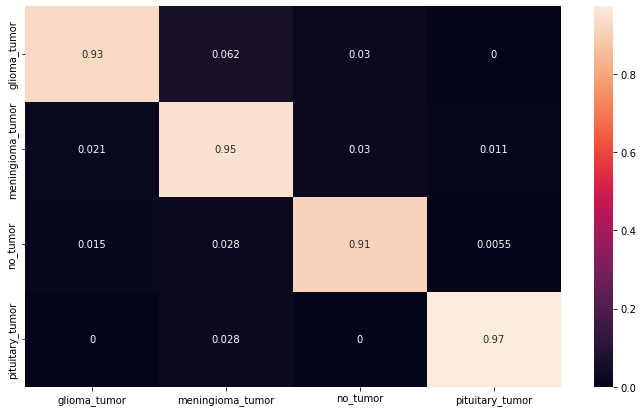

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in valid_loader:
        inputs, labels = data['image'].to(device), data['label'].to(device)# on G
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ["glioma_tumor", "meningioma_tumor","no_tumor", "pituitary_tumor"]

# Build confusion matrix
print(classification_report(y_true, y_pred))
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/ np.sum(cf_matrix, axis=1) , index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:
device = torch.device("cuda:0")
extractor = model
extractor.fc = nn.Identity() 
extractor.to(device)
extractor.eval()



def get_extracted_data(data_loader):
    for bi, d in enumerate(data_loader):
        print(".", end="")
        img_tensor = d["image"].to(device)
        target = d["label"].numpy()
        with torch.no_grad(): feature = extractor(img_tensor)
        feature = feature.cpu().detach().squeeze(0).numpy()
        if bi == 0 :
            features = feature 
            targets = target 
        else :
            features = np.concatenate([features, feature], axis=0)
            targets = np.concatenate([targets, target], axis=0)
    print("")
    return features, targets

print(".............................")
features_train, targets_train = get_extracted_data(train_loader)
features_eval, targets_eval = get_extracted_data(valid_loader)

In [152]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svm = SVC()
svm.fit(features_train, targets_train)
pred = svm.predict(features_eval)
print("acc score", accuracy_score(targets_eval, pred))


SVC()